# Text Analysis

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from utils.analysis_helpers import *

## Choose the data to analyse
- Drop or select specifics conditions
- Differentiate between Participant & Interviewer 

In [23]:
directory = '../Dataset/meditation_interviews/transcripts_per_interview/csv/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_speaker_labels(df_all)
df_all['Word Count'] = df_all['Content'].apply(lambda x: len(x.split()))

df_all.to_csv("outputs/transcripts_merged.csv", index=False)

Found 82 CSV files.


In [24]:
print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [25]:
# If we only want to focus only on the Participant or Interviewer speaker
df_participant = df_all[df_all["Speaker"] == "Participant"].copy()
df_interviewer = df_all[df_all["Speaker"] == "Interviewer"].copy()

## Word Count

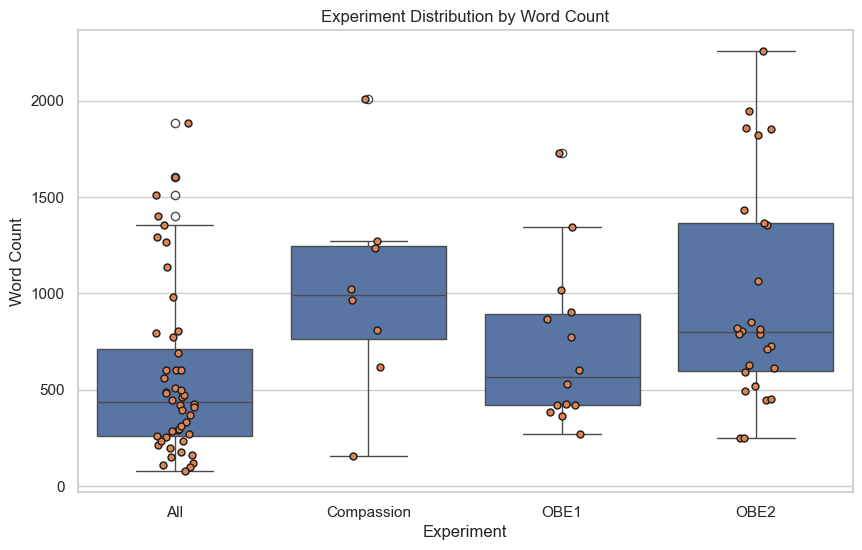

In [26]:
# Add a new row for the "All" category
df_word = aggregate_counts(df_participant,["Experiment","Id"]).copy()
df_word['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df_word,aggregate_counts(df_all,["Experiment","Id"])])

stripplot(df_combined, 'Experiment', 'Word Count')

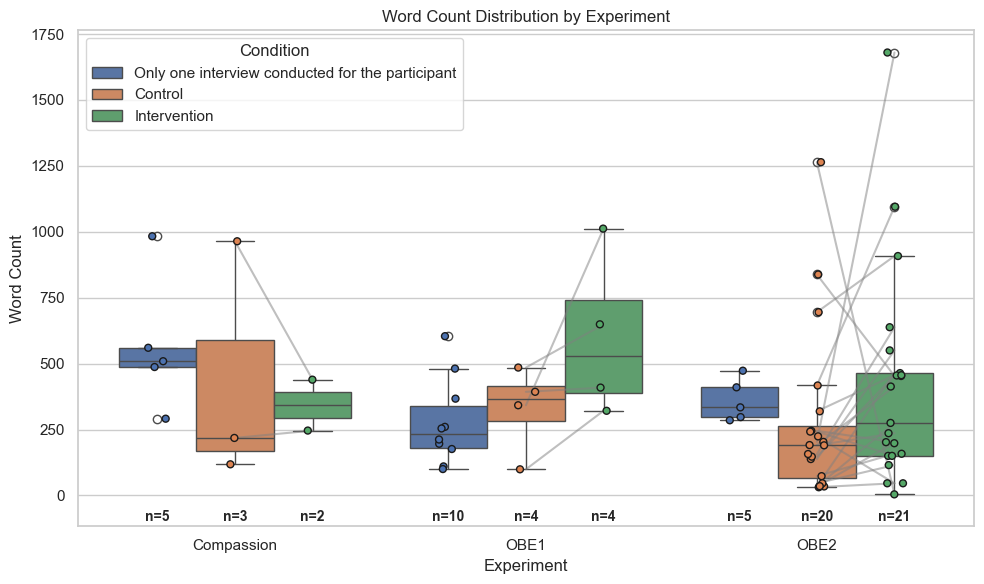

In [27]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only one interview conducted for the participant","Control","Intervention"] ,file_name="images/conditions_distribution.png")

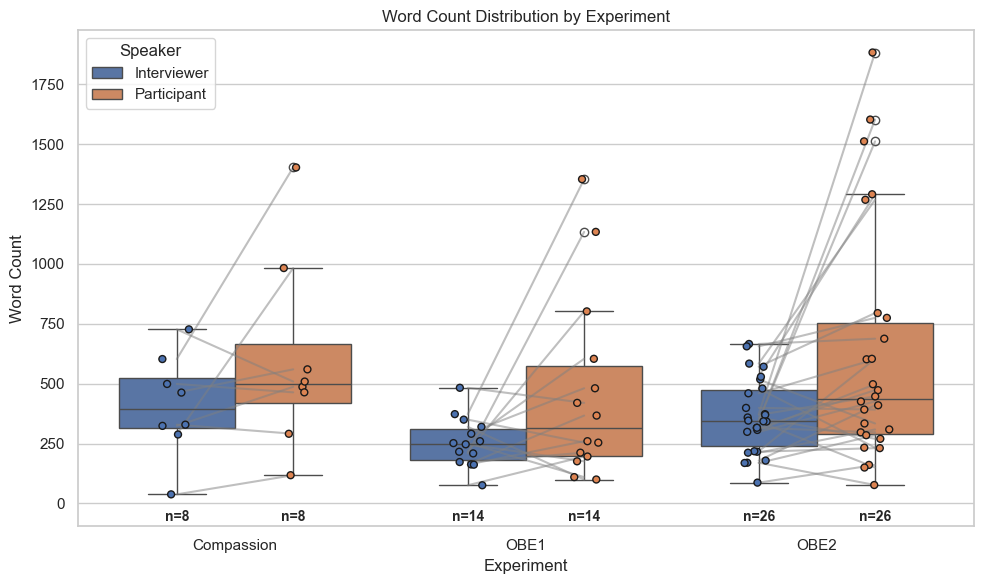

In [28]:
stripplot_with_counts(aggregate_counts(df_all, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word Count', hue_column='Speaker', id_column="Id")

# Interviewers Distribution

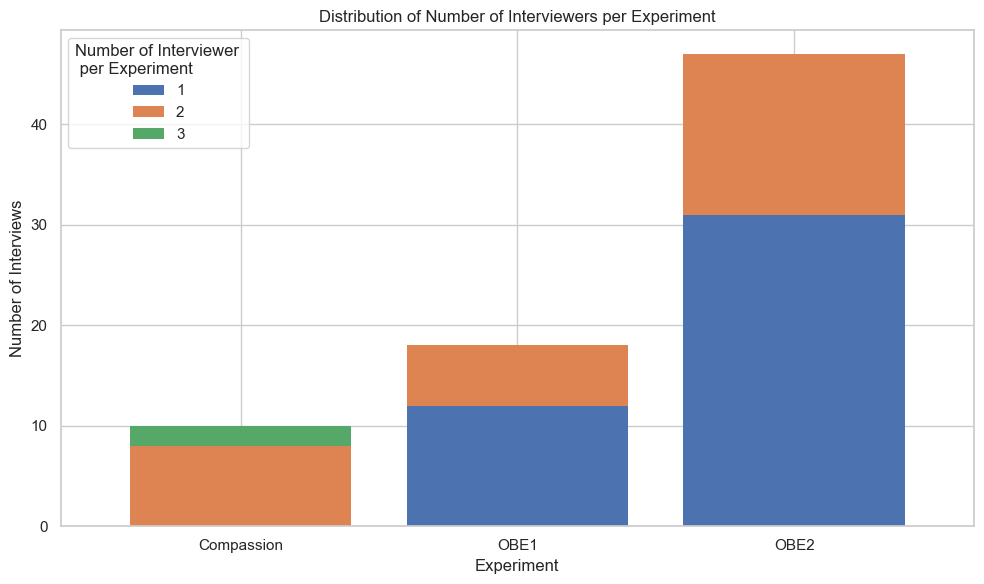

In [29]:
# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Aggregate counts for each experiment and interviewer category
experiment_summary = experimenter_count.groupby(['Experiment', 'Number of Interviewers'])['File Name'].count().reset_index()
experiment_summary.rename(columns={'File Name': 'Count'}, inplace=True)

# Step 4: Ensure all categories are represented
categories = list(range(1, experimenter_count['Number of Interviewers'].max() + 1))  # 1, 2, 3, etc.
all_experiments = experiment_summary['Experiment'].unique()
full_summary = pd.DataFrame(
    [(experiment, category) for experiment in all_experiments for category in categories],
    columns=['Experiment', 'Number of Interviewers']
).merge(experiment_summary, on=['Experiment', 'Number of Interviewers'], how='left').fillna(0)

# Convert counts to integers for clarity
full_summary['Count'] = full_summary['Count'].astype(int)

# Convert the Number of Interviewers to string for grouped bar chart
full_summary['Number of Interviewers'] = full_summary['Number of Interviewers'].astype(str)

# Step 5: Stacked bar chart
stacked_data = full_summary.pivot(index='Experiment', columns='Number of Interviewers', values='Count').fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, linewidth=0)

# Add labels and title
plt.title("Distribution of Number of Interviewers per Experiment")
plt.ylabel("Number of Interviews")
plt.xlabel("Experiment")
plt.xticks(rotation=0)
plt.legend(title="Number of Interviewer \n per Experiment")

plt.tight_layout()
plt.savefig("images/number_of_interviewers_per_experiment.png")
plt.show()

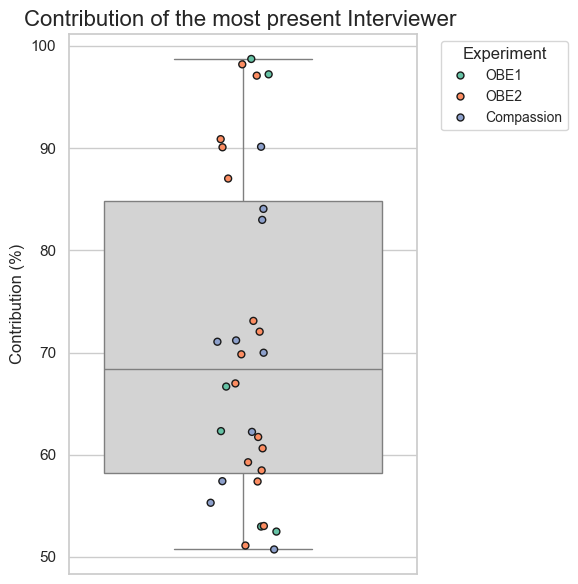

In [30]:
# Step 1: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 2: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 3: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

plt.figure(figsize=(6, 6))
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')
sns.stripplot(data=dominance, y='Dominance (%)', hue="Experiment", jitter=True, edgecolor='k', linewidth=1, palette="Set2")

# Add titles and labels
plt.title("Contribution of the most present Interviewer ", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)
# put legend outside of the plot
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig("images/most_present_interviewer.png", dpi=600)
plt.show()

In [31]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (
    filtered_df.groupby(['Id', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (
    interviewer_counts.groupby('Id')['Number of Interviewers']
    .nunique()
    .reset_index()
)
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Display results
if participants_with_changes.empty:
    print("All participants have consistent numbers of interviewers across their interviews.")
else:
    print("The following participants have varying numbers of interviewers across their interviews:")
    print(participants_with_changes)

The following participants have varying numbers of interviewers across their interviews:
     Id  Unique Interviewer Counts
3    13                          2
9    19                          2
13   24                          2
17  204                          2
18  205                          2
20  207                          2
22  209                          2
31  220                          2
39  230                          2
41  302                          2


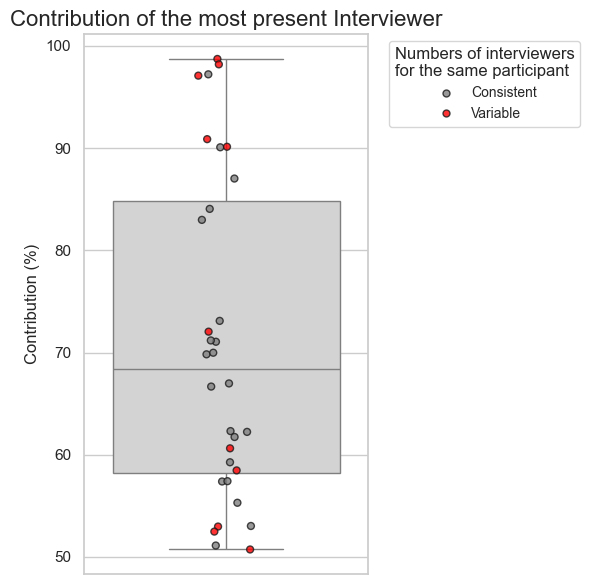

In [32]:
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]
inconsistent_interviews = detailed_changes['File Name'].unique()  

# Add a new column to classify the points for hue
dominance['Highlight'] = dominance['File Name'].apply(
    lambda x: 'Variable' if x in inconsistent_interviews else 
              'Consistent'
)

plt.figure(figsize=(6, 6))
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')

sns.stripplot(
    data=dominance,
    y='Dominance (%)',
    hue='Highlight',  # Use the new column to distinguish points
    jitter=True,
    edgecolor='k',
    linewidth=1,
    alpha=0.8,
    palette={'Variable': 'red', 'Consistent': 'gray'},
)

plt.title("Contribution of the most present Interviewer", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)
plt.legend(title="Numbers of interviewers\nfor the same participant", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig("images/most_present_interviewer_inconsistent.png", dpi=600)
plt.show()

# Key-words Analysis

We can perform the same analysis for the Interviewer text and/or both combine.

In [33]:
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like","see",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little"
]

# Remove from the default stopwords list (spacy)
retain_stopwords=["see", "yourself", "myself"]

df_participant['preprocessed_content'] = df_participant['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords,retain_stopwords=retain_stopwords))

## Words Frequency

### Word frequency by Experiement

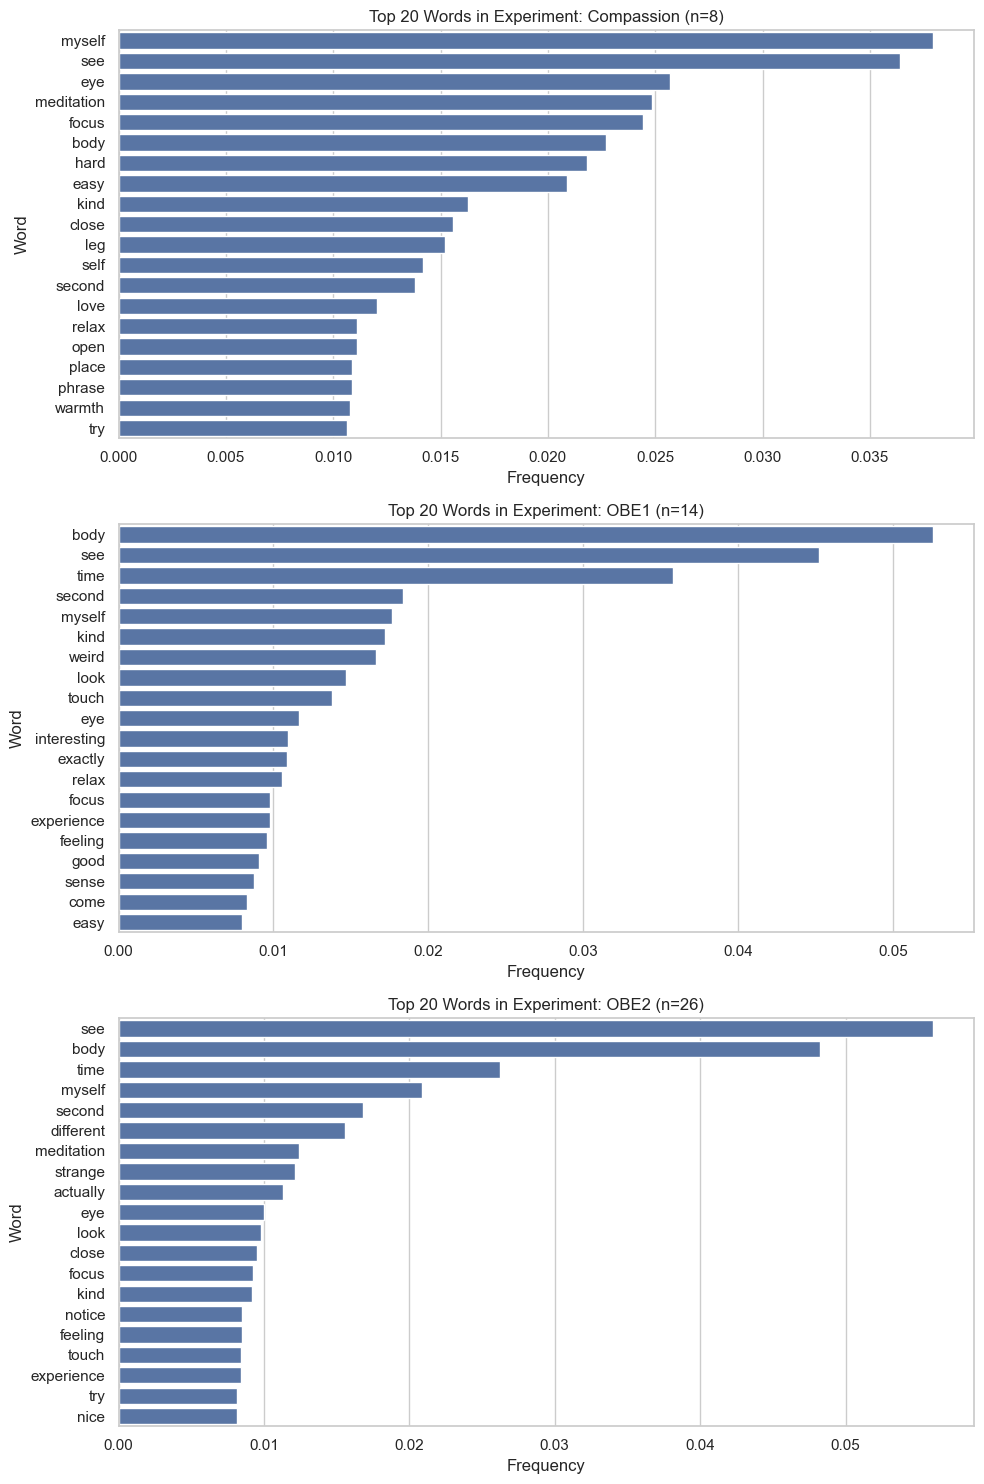

In [34]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')

### Word frequency by experiment & condition

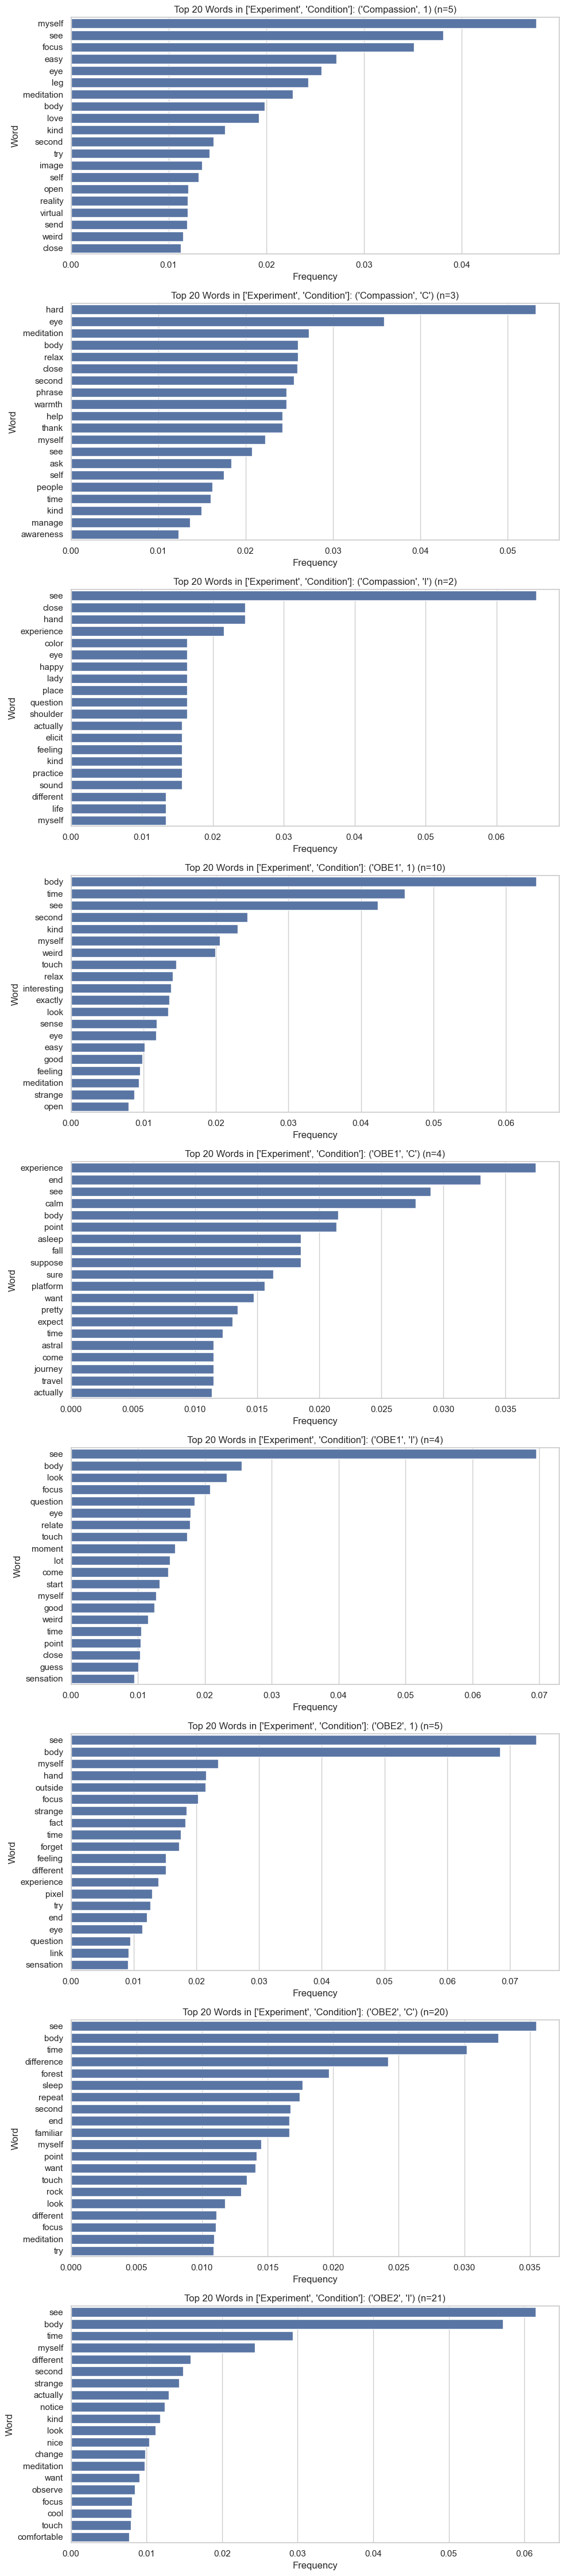

In [35]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['File Name','Experiment','Condition'], normalize=True)
plot_word_frequencies(words_feq, groupby_column=['Experiment','Condition'], level_column='File Name')

## Shared participants uniques words 

#### By Experiment

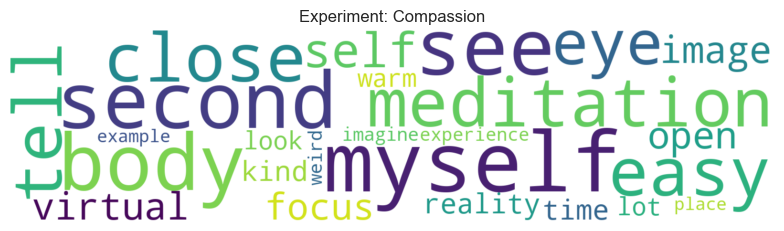

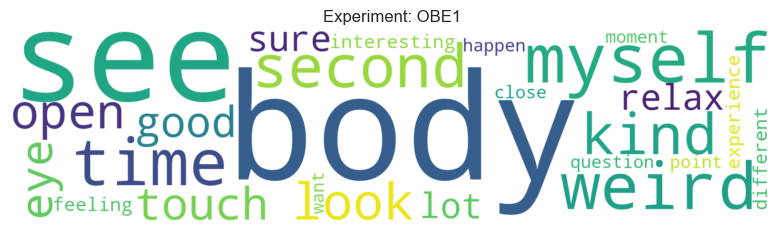

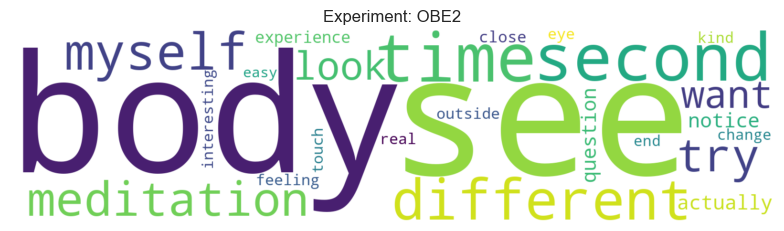

In [36]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment'])

#### By Condition

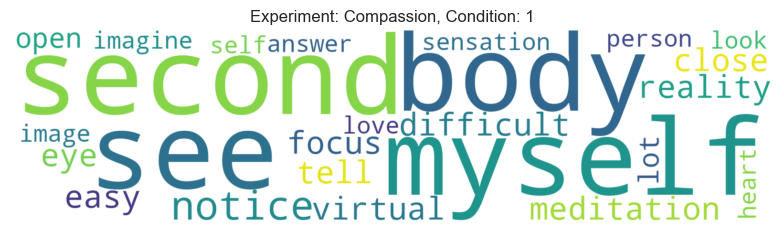

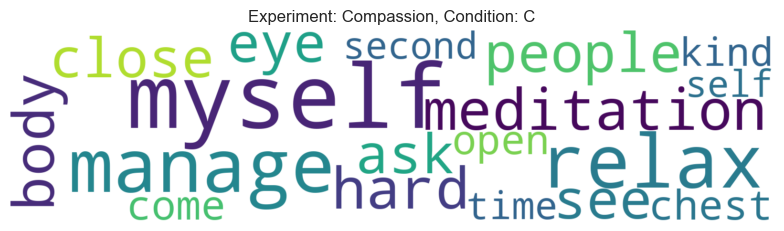

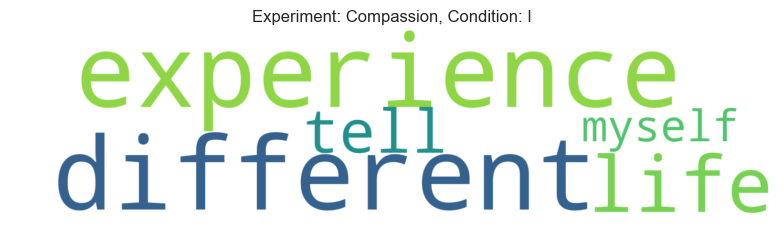

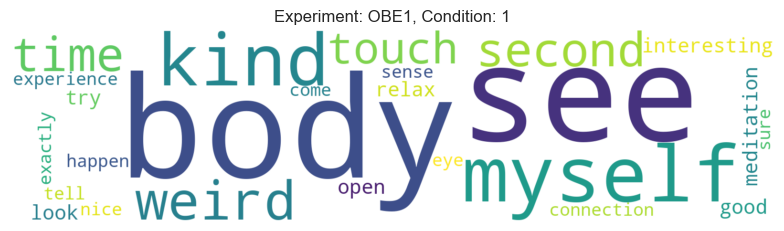

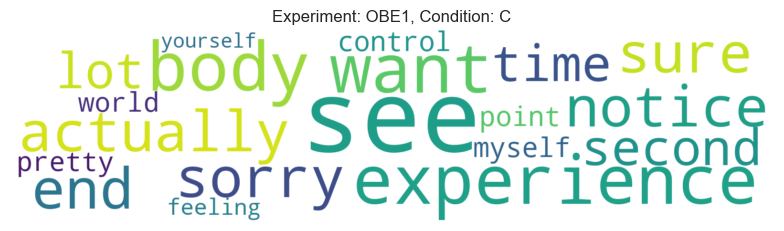

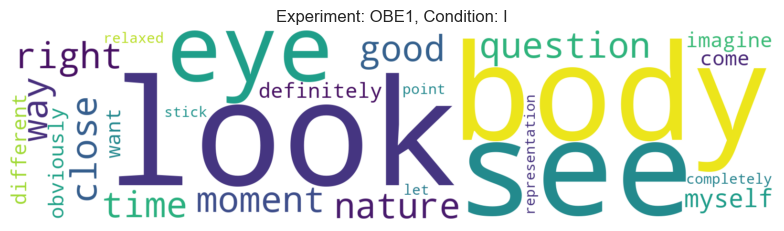

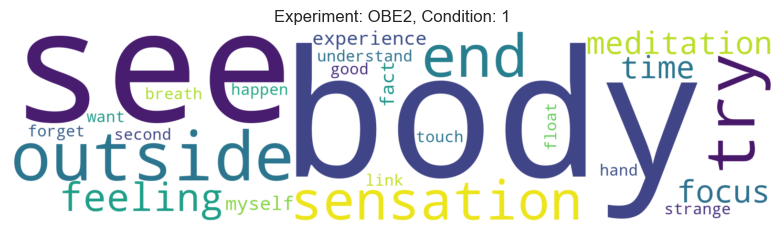

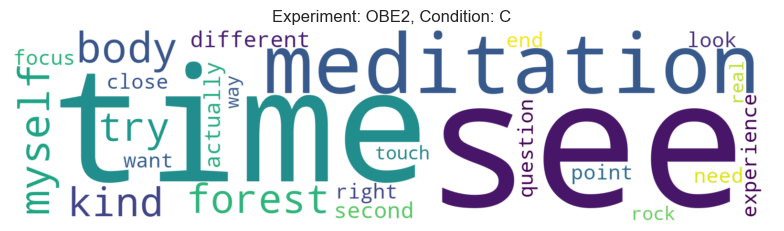

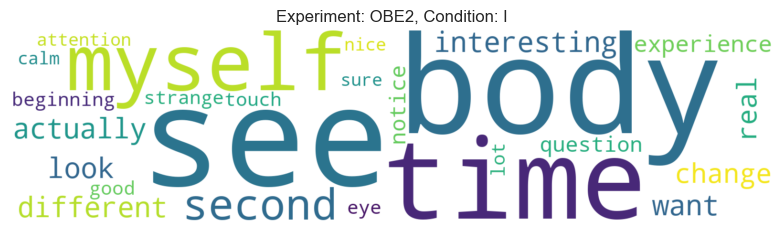

In [37]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment',"Condition"])

### Merge OBE1 and OBE2 for presentation

In [38]:
# Drop the row witcompassion experiments
df_participant_merged_OBE = df_participant.copy()
df_participant_merged_OBE.Experiment = df_participant_merged_OBE.Experiment.replace({"OBE1": "OBE", "OBE2": "OBE"})

df_participant_merged_OBE.Experiment.unique()

array(['Compassion', 'OBE'], dtype=object)

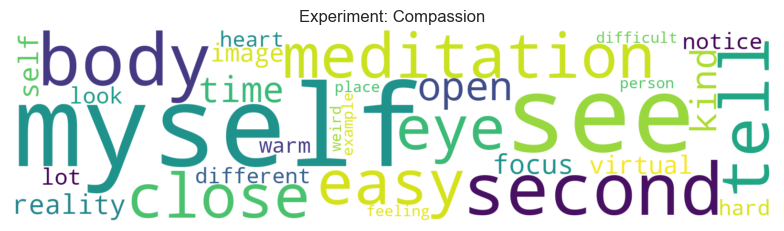

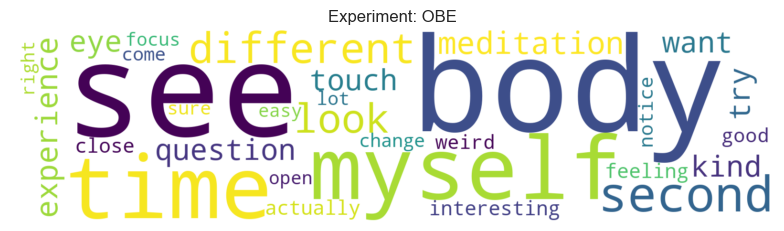

In [39]:
unique_words_df_participant = count_unique_words(df_participant_merged_OBE, groupby_columns=['Experiment'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=30, groupby_columns=['Experiment'], save_fig=True)

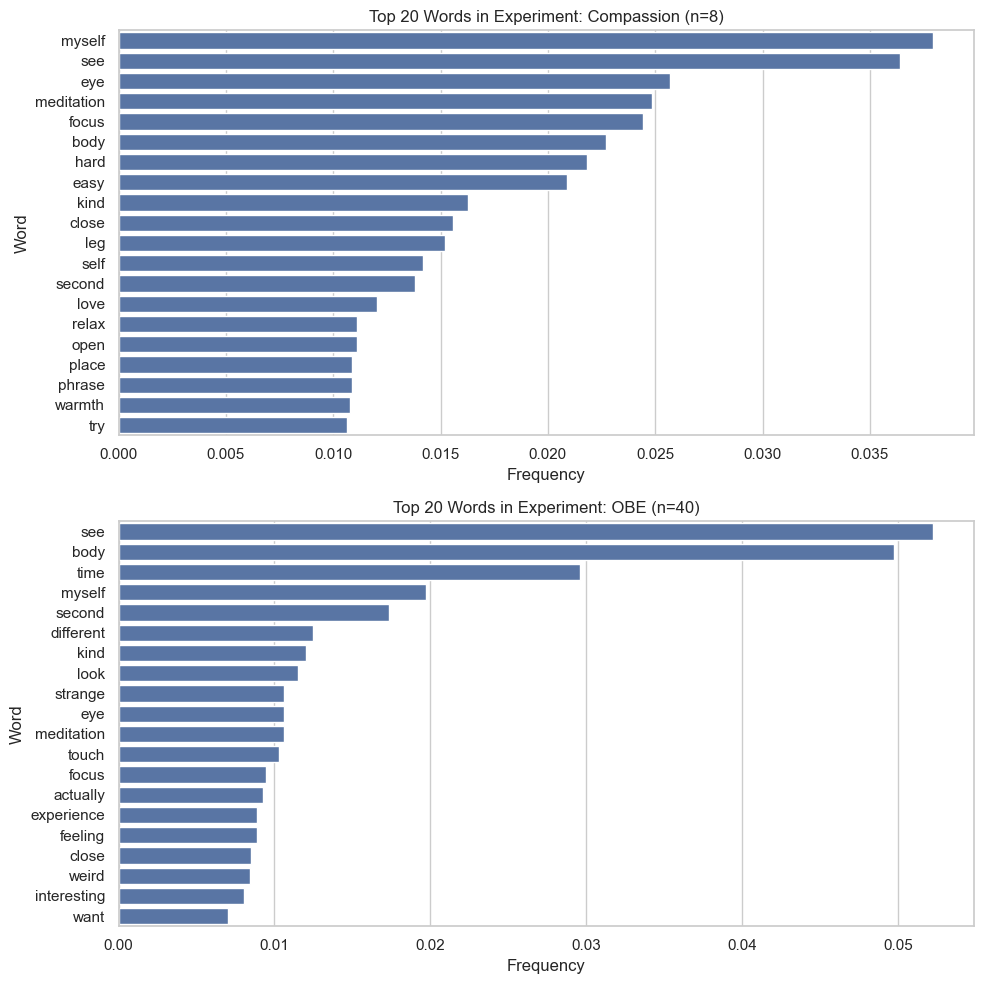

In [40]:
words_feq = count_word_frequencies(df_participant_merged_OBE, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')